# Deep Learning Based Spleen Injury Detection


integrating MONAI into an PyTorch medical DL program.

using below features:
1. Transforms for dictionary format data.
1. Load Nifti image with metadata.
1. Add channel dimensions to the data if no channel dimension.
1. Scale medical image intensity with expected range.
1. Crop out a batch of balanced images based on positive / negative label ratio.
1. Cache IO and transforms to accelerate training and validation.
1. 3D UNet model, Dice loss function, Mean Dice metric for 3D segmentation task.
1. Sliding window inference method.
1. Deterministic training for reproducibility.

## Setuping up the environment

In [1]:
!pip -q install monai gdown einops mlflow pynrrd torchinfo 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
cudf 21.10.1 requires cupy-cuda110, which is not installed.
beatrix-jupyterlab 3.1.4 requires google-cloud-bigquery-storage, which is not installed.
yellowbrick 1.3.post1 requires numpy<1.20,>=1.16.0, but you have numpy 1.21.5 which is incompatible.
thinc 8.0.13 requires typing-extensions<4.0.0.0,>=3.7.4.1; python_version < "3.8", but you have typing-extensions 4.7.1 which is incompatible.
tfx-bsl 1.4.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.4.0 requires numpy<1.20,>=1.16, but you have numpy 1.21.5 which is incompatible.
tfx-bsl 1.4.0 

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    Flipd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    RandAffined,
    Resized,
    Rand3DElasticd,
    RandFlipd,
    RandRotated,
    Rotated,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet,SwinUNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric,HausdorffDistanceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import numpy as np

## Setting up imports

In [4]:
# Copyright 2024 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 1.1.0
Numpy version: 1.19.5
Pytorch version: 1.9.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: a2ec3752f54bfc3b40e7952234fbeb5452ed63e3
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.7
Nibabel version: 3.2.1
scikit-image version: 0.18.3
Pillow version: 8.2.0
Tensorboard version: 2.6.0
gdown version: 4.7.3
TorchVision version: 0.10.1
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.3.4
einops version: 0.6.1
transformers version: 4.12.5
mlflow version: 1.30.1
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [5]:
!nvidia-smi

Mon Aug 12 09:37:51 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
directory = '..//input//spleenct'
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)
root2_dir = './'

..//input//spleenct


# dataset

Downloading and extracting the dataset.

In [7]:
set_determinism(seed=0)

In [8]:

resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
print(data_dir)
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

..//input//spleenct/Task09_Spleen


## Set MSD Spleen dataset path

In [9]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
# train_files, val_files = data_dicts[:-9], data_dicts[-9:]

In [10]:

import random
x=[i for i in range(41)]
print(x)
random.shuffle(x)
print(x)
train_index,val_index,test_index=x[:33],x[33:],x[33:]
train_files=[]
val_files=[]
test_files=[]
for i in train_index:
    train_files.append(data_dicts[i])
for i in val_index:
    val_files.append(data_dicts[i])
for i in test_index:
    test_files.append(data_dicts[i])
 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
[0, 29, 12, 20, 36, 15, 27, 11, 1, 21, 7, 5, 10, 13, 14, 38, 23, 34, 40, 35, 17, 8, 33, 3, 39, 9, 4, 37, 6, 28, 18, 22, 30, 19, 25, 31, 32, 16, 2, 26, 24]


## Set deterministic training for reproducibility

## Setuping up transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.
1. `EnsureTyped` converts the numpy array to PyTorch Tensor for further steps.

In [11]:
newsize=(128,128,-1)
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"],spatial_size=newsize),

        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        RandAffined(
            keys=['image', 'label'],
            mode=('bilinear', 'nearest'),
            prob=0.5, spatial_size=(-1, -1, -1),
            rotate_range=(0, 0, np.pi/15),
            scale_range=(0.1, 0.1, 0.1)),
        RandFlipd(
            keys=['image', 'label'],
            prob=0.5, 
            spatial_axis=1,
        ),
#         Rand3DElasticd(
#             keys=["image", "label"],
#             sigma_range=(5,8),
#             rotate_range=(-np.pi/15,np.pi/15),
#             shear_range=(-0.1,0.1),
#             scale_range=(-0.1,0.1),
#             translate_range=(-15,15),  
#             mode='nearest',
#             prob=0.9, 
#             magnitude_range=(-0.1,0.1)  
#         ),
        # user can also add other random transforms

        EnsureTyped(keys=["image", "label"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Resized(keys=["image", "label"],spatial_size=newsize),
        EnsureTyped(keys=["image", "label"]),
    ]
)

## Check transforms in DataLoader

torch.Size([4, 1, 96, 96, 96])
image shape: torch.Size([96, 96, 96]), label shape: torch.Size([96, 96, 96])


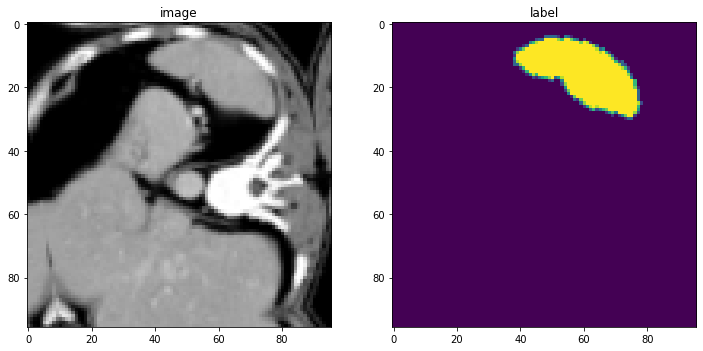

In [12]:
check_ds = Dataset(data=val_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
for check_data in check_loader:
    print(check_data['image'].shape)
    break
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 60], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 60])
plt.show()

## Defining CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, seting `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
we can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to try the regular Dataset, just change to use the commented code below.

In [13]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=0.1, num_workers=4)
# train_ds = monai.data.Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=0.1, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)
test_ds =Dataset(
    data=test_files, transform=val_transforms)

test_loader = DataLoader(test_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


## Creating Model, Loss, Optimizer

In [14]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

# model = SwinUNETR(
#    img_size=(96,96,96), 
#    in_channels=1, 
#    out_channels=2,
# ).to(device)

loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")
hd95_metric=HausdorffDistanceMetric(include_background=False, reduction="mean",percentile=95)

## Executing a typical PyTorch training process

In [15]:
max_epochs = 90
val_interval = 2
best_metric = -1
best_metric_epoch = -1
best_metric2 = -1
best_metric2_epoch = -1
epoch_loss_values = []
metric_values = []
metric2_values = []

post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([EnsureType(), AsDiscrete(to_onehot=2)])

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
            
        )
        print(inputs.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, "f"train_loss: {loss.item():.4f}")
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    #print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
#                 print(val_inputs.shape)#
                roi_size = (96, 96, 96)#
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
#                 print('1',val_outputs.shape)
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
#                 print('2',val_outputs[0].shape) #213，217，113
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)
                hd95_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            metric2=hd95_metric.aggregate().item()
            # reset the status for next validation round
            dice_metric.reset()
            hd95_metric.reset()

            metric_values.append(metric)
            metric2_values.append(metric2)
            if metric > best_metric:
                best_metric = metric
                best_metric2=metric2
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root2_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f"\nbest mean dice: {best_metric:.4f},hd:{best_metric2:.4f} "
                f"at epoch: {best_metric_epoch}"
            )

----------
epoch 1/90
torch.Size([4, 1, 96, 96, 96])
1/33, train_loss: 0.6891
torch.Size([4, 1, 96, 96, 96])
2/33, train_loss: 0.6905
torch.Size([4, 1, 96, 96, 96])
3/33, train_loss: 0.6718
torch.Size([4, 1, 96, 96, 96])
4/33, train_loss: 0.6809
torch.Size([4, 1, 96, 96, 96])
5/33, train_loss: 0.6845
torch.Size([4, 1, 96, 96, 96])
6/33, train_loss: 0.6781
torch.Size([4, 1, 96, 96, 96])
7/33, train_loss: 0.6780
torch.Size([4, 1, 96, 96, 96])
8/33, train_loss: 0.6743
torch.Size([4, 1, 96, 96, 96])
9/33, train_loss: 0.6606
torch.Size([4, 1, 96, 96, 96])
10/33, train_loss: 0.6691
torch.Size([4, 1, 96, 96, 96])
11/33, train_loss: 0.6671
torch.Size([4, 1, 96, 96, 96])
12/33, train_loss: 0.6668
torch.Size([4, 1, 96, 96, 96])
13/33, train_loss: 0.6669
torch.Size([4, 1, 96, 96, 96])
14/33, train_loss: 0.6677
torch.Size([4, 1, 96, 96, 96])
15/33, train_loss: 0.6616
torch.Size([4, 1, 96, 96, 96])
16/33, train_loss: 0.6624
torch.Size([4, 1, 96, 96, 96])
17/33, train_loss: 0.6641
torch.Size([4, 1, 

In [16]:
print(
    f"train completed, best_metric: {best_metric:.4f} ,best_hd:{best_metric2:.4f}"
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.8958 ,best_hd:1.9953at epoch: 82


## Ploting the loss and metric

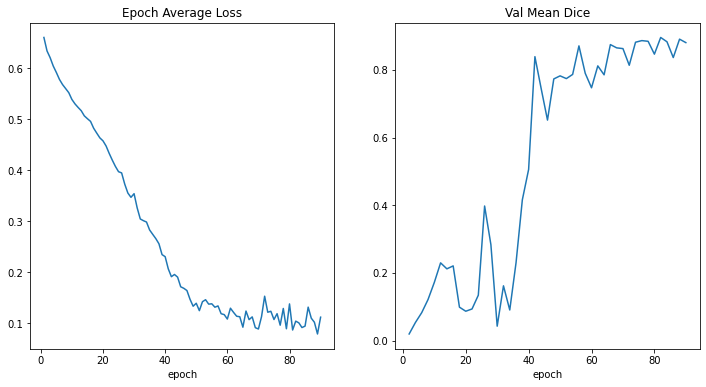

In [17]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Checking for best model output with the input image and label

0


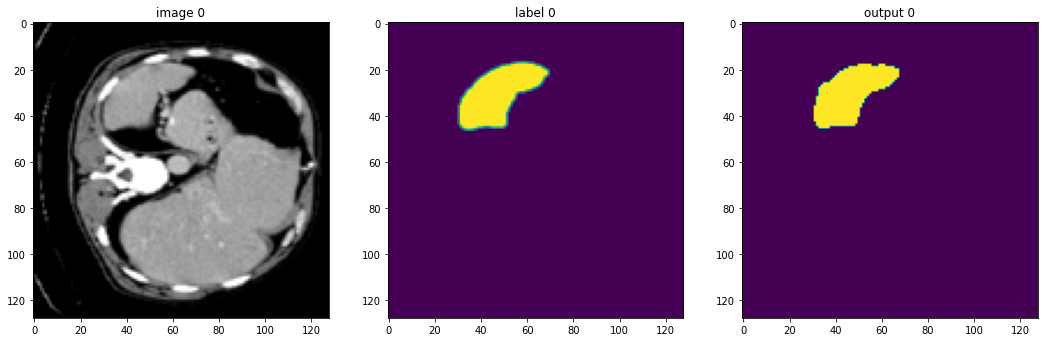

1


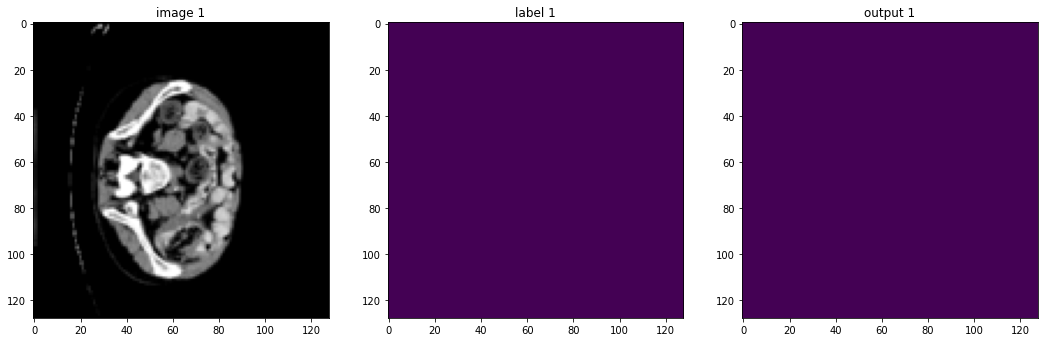

2


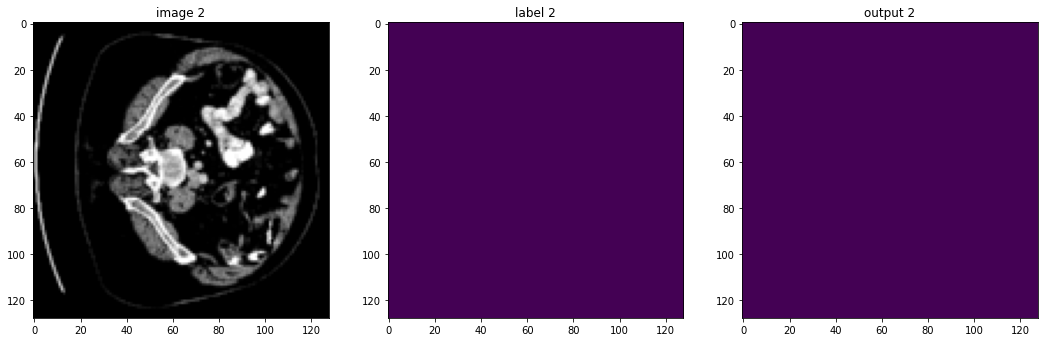

3


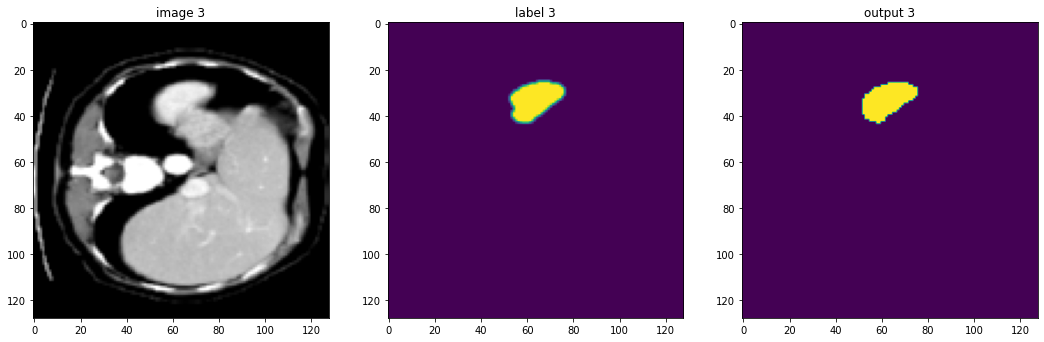

4


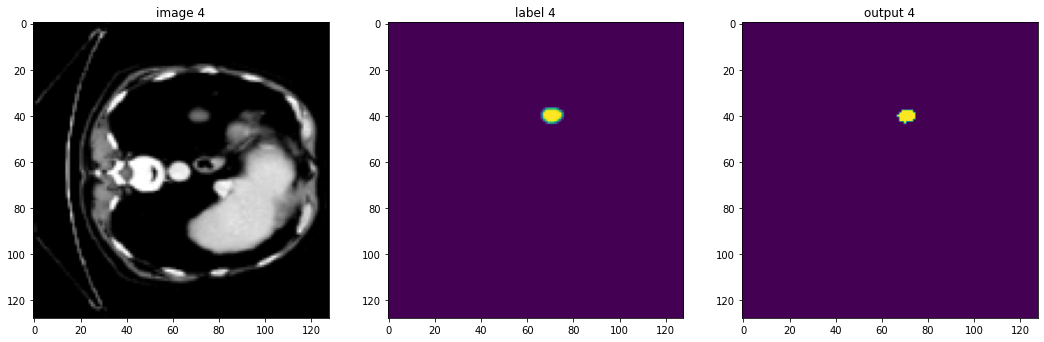

5


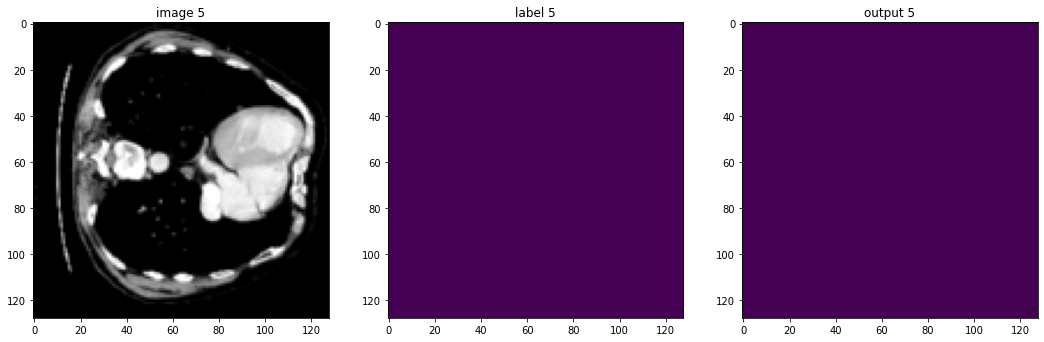

6


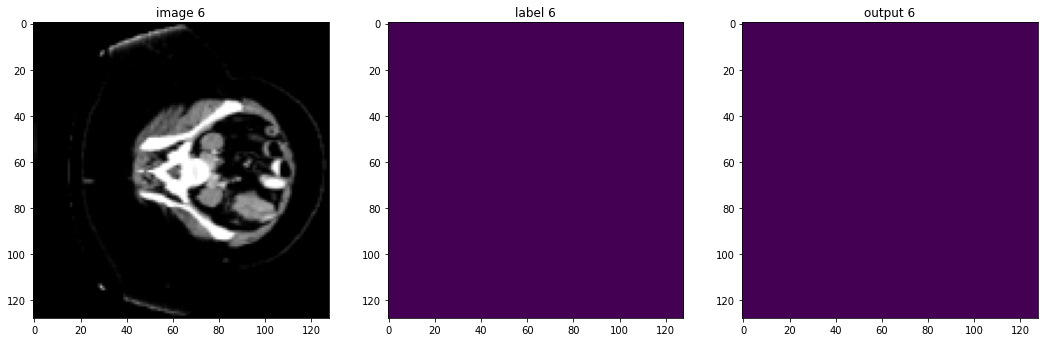

7


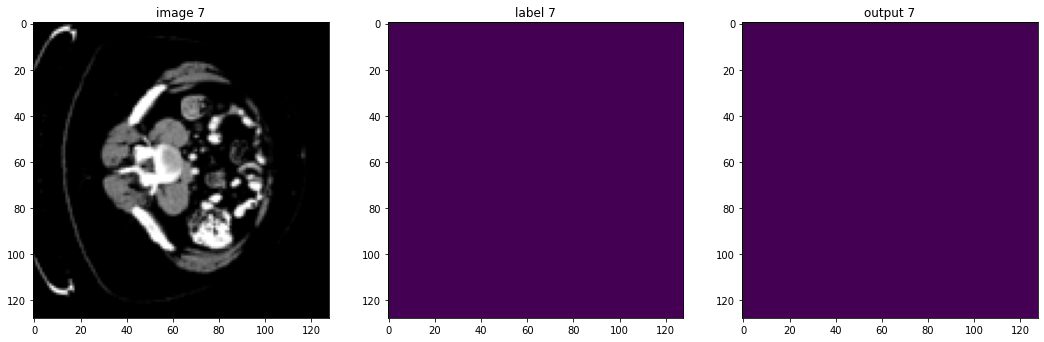

In [18]:
model.load_state_dict(torch.load(
    os.path.join(root2_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model)
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        print(i)
        plt.imshow(val_data["image"][0, 0, :, :, 90], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 90])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 90])
        plt.show()
        if i == 7:
            break

## Evaluation on test data

In [19]:
model.load_state_dict(torch.load(
    os.path.join(root2_dir, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for test_data in test_loader:
        test_inputs = test_data["image"].to(device)
        test_labels = test_data["label"].to(device)
#         print(test_inputs.shape,test_labels.shape)
        roi_size = (96, 96, 96)
        sw_batch_size = 4
        test_outputs = sliding_window_inference(
            test_inputs, roi_size, sw_batch_size, model)
        test_outputs = [post_pred(i) for i in decollate_batch(test_outputs)]
        test_labels = [post_label(i) for i in decollate_batch(test_labels)]
#                
        # compute metric for current iteration
#         val_outputs.to(device)
#         val_labels.to(device)
        dice_metric(y_pred=test_outputs, y=test_labels)
        hd95_metric(y_pred=test_outputs, y=test_labels)

    # aggregate the final mean dice result
    metric_org = dice_metric.aggregate().item()
    metric_hd = hd95_metric.aggregate().item()
    # reset the status for next validation round
    dice_metric.reset()
    hd95_metric.reset()


print("Metric on test data: ", metric_org,metric_hd)

Metric on test data:  0.895811915397644 1.9953403523436322


In [20]:
if directory is None:
    shutil.rmtree(root_dir)